In [1]:
import os
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Before starting with Exploratory Data Analysis (EDA), make you have downloaded the dataset:
https://www.kaggle.com/datasets/innominate817/hagrid-sample-30k-384p
And put it into shared_artifacts/images/hagrid_30k so that it contains train_val_call, train_val_dislike etc...

Next stage is to run the hand extraction tool, make sure you are using python 3.12
Navigate to the utils/mediapipe_cropper/ and run:
```bash
python3 cropper.py --input ../../shared_artifacts/images/hagrid_30k --output ../../shared_artifacts/images/hagrid_30k_cropped
```

In [7]:
analysis_data = []
path = 'shared_artifacts/images/hagrid_30k'
extensions = ('.jpg')
corrupted_images = 0

for class_label in os.listdir(path):
    pure_label = class_label[10:] # removes 'train_val_' prefix
    label_path = os.path.join(path, class_label)

    if os.path.exists(label_path):
        files = os.listdir(label_path)

        image_files = [f for f in files if f.lower().endswith(extensions)]

        if len(files) != len(image_files):
            print(f"Warning: Some non-image (.jpg) files found in {label_path}")

        for image in image_files:
            image_path = os.path.join(label_path, image)

            try:
                with Image.open(image_path) as img:
                    width, height = img.size
                    type = img.mode # RGB, L, etc.
                    file_size = os.path.getsize(image_path) / 1024 # KB

                    analysis_data.append({
                        'filename': image,
                        'class': pure_label,
                        'width': width,
                        'height': height,
                        'aspect_ratio': round(width/height, 2),
                        'type': type,
                        'file_size_kb': round(file_size, 2),
                        'path': image_path
                    })
                
            except Exception as e:
                print(f"Error reading {image_path}: {e}")
                corrupted_images += 1

df = pd.DataFrame(analysis_data)

In [8]:
print(f"Total images: {len(df)}")
print(f"Number of classes: {df['class'].nunique()}")
print(f"Average aspect ratio: {df['aspect_ratio'].mean():.2f}")
print(f"Average dimensions: {df['width'].mean():.2f}x{df['height'].mean():.2f}")
print(f"Min dimensions: {df['width'].min()}x{df['height'].min()}")
print(f"Max dimensions: {df['width'].max()}x{df['height'].max()}")
print(f"Average file size: {df['file_size_kb'].mean():.2f} KB")
print(f"Corrupted images: {corrupted_images}")
print(f"Types present: {df['type'].unique()}")

Total images: 31833
Number of classes: 18
Average aspect ratio: 0.88
Average dimensions: 420.01x504.01
Min dimensions: 384x384
Max dimensions: 854x1007
Average file size: 24.95 KB
Corrupted images: 0
Types present: ['RGB']


The information we have gathered so far:
- Total number of images is 31833
- Number of classes is 18
- Dimensions are ranging from 384x384 to 854x1007
- No corrupted images
- All images are in RGB format
- All files are .jpg

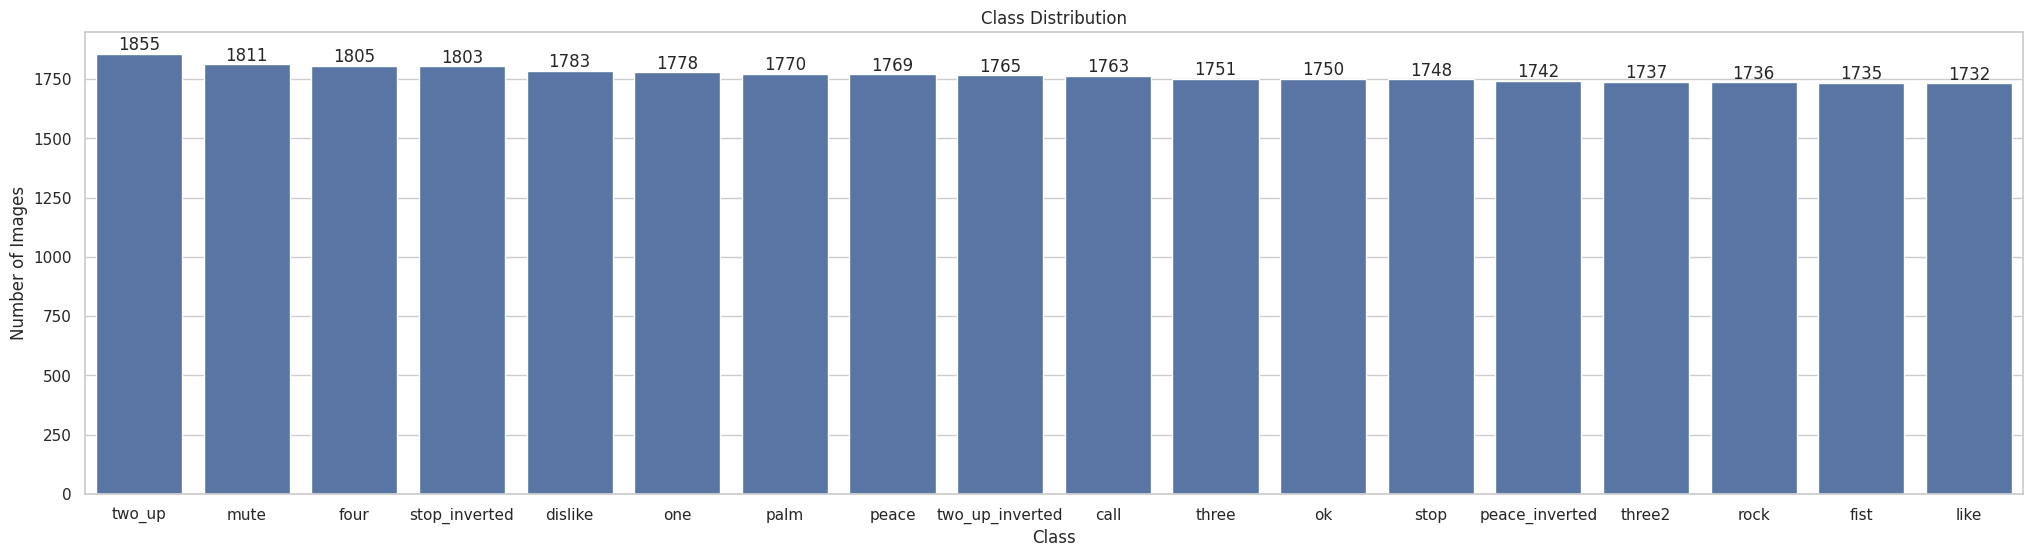

In [9]:
sns.set_theme(style="whitegrid")

# Class distribution
classes = df['class'].value_counts()
plt.figure(figsize=(25, 6))
barplot = sns.barplot(x=classes.index, y=classes.values)
barplot.bar_label(barplot.containers[0])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

In [10]:
# Dimension distribution
print(df[['width', 'height']].describe())
standard_mask = (df['width'] == 384) & (df['height'] == 512)
standard_mask_rotated = (df['width'] == 512) & (df['height'] == 384)
print(f"Standard (384×512): {standard_mask.sum()} images ({standard_mask.sum()/len(df)*100:.1f}%)")
print(f"Standard 2 (512×384): {standard_mask_rotated.sum()} images ({standard_mask_rotated.sum()/len(df)*100:.1f}%)")
print(f"Non-standard: {(~standard_mask & ~standard_mask_rotated).sum()} images ({(~standard_mask & ~standard_mask_rotated).sum()/len(df)*100:.1f}%)")

              width        height
count  31833.000000  31833.000000
mean     420.010178    504.010241
std       84.191991     89.280018
min      384.000000    384.000000
25%      384.000000    512.000000
50%      384.000000    512.000000
75%      384.000000    512.000000
max      854.000000   1007.000000
Standard (384×512): 19235 images (60.4%)
Standard 2 (512×384): 3380 images (10.6%)
Non-standard: 9218 images (29.0%)


TO-DO: Sample images, proper attribution to the dataset